In [12]:
import ssl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# 1) 파일 경로 설정
codon_file = 'gencode-exons-containing-startcodon.bed'
cov_file   = 'fivepcounts-filtered-RPF-siLuc.txt'
window = 50
bins   = np.arange(-window, window+1)

In [40]:
ssl._create_default_https_context = ssl._create_unverified_context
starts = pd.read_csv(codon_file, sep='\t', header=None,
                     names=['chrom', 'exon_start', 'exon_end', 'gene_id', 'sc_start', 'strand'])
starts['sc_start'] = pd.to_numeric(starts['sc_start'], errors='coerce').dropna().astype(int)
starts['chrom'] = starts['chrom'].str.replace('^chr', '', regex=True)

In [41]:
profile = pd.Series(0.0, index=bins)
total_genes = len(starts)

In [ ]:
def load_next_chunk(reader):
    """
    청크 단위로 읽고 전처리하여 반환
    """
    chunk = next(reader)
    # 문자열을 숫자형으로 변환
    chunk['pos']   = pd.to_numeric(chunk['pos'], errors='coerce')
    chunk['count'] = pd.to_numeric(chunk['count'], errors='coerce')
    # NaN 제거 및 타입 변환
    chunk = chunk.dropna(subset=['pos','count']).astype({'pos':'int','count':'int'})
    chunk['chrom'] = chunk['chrom'].str.replace('^chr','', regex=True)
    return chunk


In [61]:
reader = pd.read_csv(
    cov_file,
    sep='\t',
    header=None,
    usecols=[0,1,2,3],      # only these columns
    names=['chrom','pos','end','count'],
    dtype=str,
    chunksize=10**6
)

In [55]:
def aggregate_chunk(chunk, profile, starts, window):
    """
    하나의 청크에 대해 모든 염색체, 시작코돈 위치 주변 read count 집계
    """
    for chrom in starts['chrom'].unique():
        sc_positions = starts.loc[starts['chrom']==chrom, 'sc_start']
        sub_cov = chunk[chunk['chrom']==chrom]
        if sub_cov.empty:
            continue
        for sc in sc_positions:
            region = sub_cov[(sub_cov['pos'] >= sc-window) & (sub_cov['pos'] <= sc+window)]
            rel = region['pos'] - sc
            counts = region.groupby(rel)['count'].sum()
            profile = profile.add(counts, fill_value=0)
    return profile

In [62]:
while True:
    try:
        chunk = load_next_chunk(reader)
        profile = aggregate_chunk(chunk, profile, starts, window)
    except StopIteration:
        break

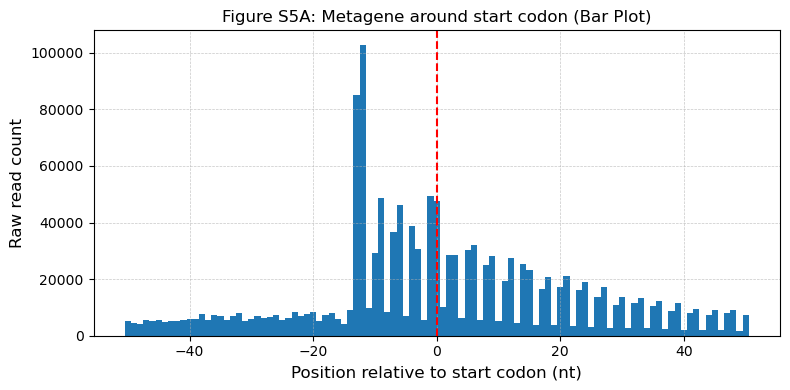

In [64]:
plt.figure(figsize=(8,4))
plt.bar(bins, profile, width=1.0)
plt.axvline(0, color='red', linestyle='--', label='Start codon')
plt.xlabel("Position relative to start codon (nt)", fontsize=12)
plt.ylabel("Raw read count", fontsize=12)
plt.title("Figure S5A: Metagene around start codon (Bar Plot)")
plt.ylim(0)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
profile

-50    0.0
-49    0.0
-48    0.0
-47    0.0
-46    0.0
      ... 
 46    0.0
 47    0.0
 48    0.0
 49    0.0
 50    0.0
Length: 101, dtype: float64

In [60]:
starts_chroms = set(starts['chrom'].unique())
print("Start codon chroms:", sorted(starts_chroms))

# coverage 청크 하나만 읽어서 chrom 집합 확인
reader = pd.read_csv(
    cov_file, sep='\t', header=None,
    names=['chrom','pos','end','count'], dtype=str, chunksize=10**6
)
first_chunk = next(reader)
cov_chroms = set(first_chunk['chrom'].str.replace('^chr','', regex=True).unique())
print("Coverage chroms:", sorted(list(cov_chroms))[:10], "…")

Start codon chroms: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', 'X', 'Y']
Coverage chroms: ['100021703', '10004149', '100076470', '100077491', '100130712', '100146155', '100165975', '100169977', '100178914', '100188161'] …
